In [2]:
import pandas as pd
import numpy as np
#Import Keras
import splitfolders
from tensorflow import keras
from keras import layers
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten ,MaxPooling2D, LSTM, Add
from keras.models import Sequential
from keras.optimizers import SGD
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

#Folder Split

In [ ]:
# Directorio que contiene tus espectrogramas de GTZAN
input_dir = "C:\Diego\music-genre-classifier\imagenes\gtzan2"

# Directorio de salida donde se guardarán los conjuntos divididos
output_dir = "C:\Diego\music-genre-classifier\imagenes\gtzan_split"

# Dividir los datos en conjuntos de entrenamiento, validación y p3#rueba

#splitfolders.ratio(input_dir, output=output_dir, seed=1337, ratio=(0.7, 0.15, 0.15))

In [1]:
from keras.preprocessing.image import ImageDataGenerator

# Directorio raíz donde se encuentran las carpetas de las clases
data_dir = 'C:\Diego\music-genre-classifier\imagenes\gtzan2_split'
train_dir = f"{data_dir}/train"
val_dir = f"{data_dir}/val"
test_dir = f"{data_dir}/test"
# Dimensiones de las imágenes
img_width, img_height = 216, 224
# Batch size
batch_size = 64

# Crear generador de datos
datagen = ImageDataGenerator(
    rescale=1./255, 

         # Normalizar los valores de píxeles entre 0 y 1
  )    # Proporción de datos para validación y prueba

# Generador de datos para entrenamiento y validación (incluyendo la división)
train_generator = datagen.flow_from_directory(
    train_dir,                       # Directorio raíz
    target_size=(img_width, img_height),  # Dimensiones de las imágenes
    batch_size=batch_size,          # Tamaño del batch
    class_mode='categorical',       # Modo de clasificación categórica
  shuffle=True
  )              # Usar conjunto de entrenamiento

# Generador de datos para validación
validation_generator = datagen.flow_from_directory(
    val_dir,                       # Directorio raíz
    target_size=(img_width, img_height),  # Dimensiones de las imágenes
    batch_size=batch_size,          # Tamaño del batch
   shuffle=True

    )            # Usar conjunto de validación

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),  # Dimensiones de las imágenes
    batch_size=batch_size, 
      shuffle=False

)

Found 8382 images belonging to 10 classes.
Found 1794 images belonging to 10 classes.
Found 1802 images belonging to 10 classes.


In [ ]:
class_names = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
_, train_counts = np.unique(train_generator.classes, return_counts=True)
_, test_counts = np.unique(test_generator.classes, return_counts=True)
_, val_counts = np.unique(validation_generator.classes, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts,
                    'validation': val_counts}, 
             index=class_names
            ).plot.bar()
plt.savefig('distribution.pdf',dpi=1200)
plt.show()
train_counts

In [ ]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0,0,0,0,0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each category')
plt.savefig('proportion.pdf',dpi=1200)
plt.show()

Modelo 1: 86%

In [ ]:
def conv_block(model, filters, kernel_size,pooling=True):
    model.add(Conv2D(filters, kernel_size, padding="same", activation="relu"))
    if pooling:
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))
  
model = Sequential()
input_shape=(img_width,img_height,3)#1st hidden layer
model.add(Conv2D(32, 3, input_shape=input_shape,activation="relu"))
model.add(Dropout(0.1))

model.add(Activation('relu'))#2nd hidden layer
model.add(MaxPooling2D())
conv_block(model,32,5)
model.add(Dropout(0.1))

conv_block(model,64,5)
model.add(Dropout(0.1))

conv_block(model,128,5)
model.add(Dropout(0.1))

conv_block(model,128,5)


model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))

model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=["categorical_accuracy"],

)
epochs = 70
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history = model.fit(train_generator,
                    validation_data = validation_generator,
                    steps_per_epoch = train_generator.n//train_generator.batch_size,
                    validation_steps = validation_generator.n//validation_generator.batch_size,
                    epochs=epochs, callbacks=[early_stopping])

In [11]:
#Training model with filters=[32, 64, 64, 128], dropout=0.1, dense=[512, 256]
from tensorflow.keras.initializers import RandomNormal, HeNormal
def conv_block(model, filters, kernel_size,pooling=True):
    model.add(Conv2D(filters, kernel_size, padding="same", activation="relu",kernel_initializer=RandomNormal()))
    if pooling:
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model = Sequential()
input_shape=(img_width,img_height,3)#1st hidden layer
model.add(Conv2D(32, 3, input_shape=input_shape,activation="relu",kernel_initializer=HeNormal()))
model.add(MaxPooling2D())

model.add(Dropout(0.05))
conv_block(model,32,5)
model.add(Dropout(0.05))
conv_block(model,64,5)

conv_block(model,64,5)

conv_block(model,128,5)
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(512,activation="relu",kernel_initializer=HeNormal()))
model.add(Dropout(0.1))
model.add(Dense(256,activation="relu",kernel_initializer=HeNormal()))
model.add(Dropout(0.1))
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()


model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=["categorical_accuracy"],

)
epochs = 70
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history = model.fit(train_generator,
                    validation_data = validation_generator,
                    steps_per_epoch = train_generator.n//train_generator.batch_size,
                    validation_steps = validation_generator.n//validation_generator.batch_size,
                    epochs=epochs, callbacks=[early_stopping])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 214, 222, 32)      896       
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 107, 111, 32)     0         
 g2D)                                                            
                                                                 
 dropout_31 (Dropout)        (None, 107, 111, 32)      0         
                                                                 
 conv2d_28 (Conv2D)          (None, 107, 111, 32)      25632     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 53, 55, 32)       0         
 g2D)                                                            
                                                                 
 dropout_32 (Dropout)        (None, 53, 55, 32)       

In [ ]:
filters_per_layer = [[32, 64, 128, 128], [32, 64, 64, 128], [32, 64, 128, 256]]
dropout_rate = [0.1, 0.3]
dense_units = [[1024, 256], [512, 256], [128, 64]]
best_accuracy = 0
for filters in filters_per_layer:
    for dropout in dropout_rate:
        for dense in dense_units:
            model = create_model(filters_per_layer=filters, dropout_rate=dropout, dense_units=dense, input_shape=(img_width, img_height, 3))
            print('Training model with filters={}, dropout={}, dense={}'.format(filters, dropout, dense))
            model.fit(train_generator, validation_data=validation_generator, epochs=10, verbose=0)
            accuracy = model.evaluate(test_generator)[1]
            print('Accuracy:', accuracy)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model = model

In [2]:
score = model.evaluate(
                        test_generator,
                        verbose = 1
                    )  


NameError: name 'model' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming model.predict(test_generator) returns the predicted labels
# and test_generator.classes gives the true labels

# Replace these with your actual predicted and true labels
predicted_labels = model.predict(test_generator)
true_labels = test_generator.classes

In [ ]:
history.history.keys()

In [ ]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(15,12))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['categorical_accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_categorical_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.savefig('accuracy_loss.pdf',dpi=1200)
    plt.show()
plot_accuracy_loss(history)

In [ ]:
for predicted, label in zip(predicted_labels, true_labels):
    print("predicted: ",np.argmax(predicted), "!!!real :", label)

In [ ]:
import seaborn as sn
cm = confusion_matrix(true_labels, np.argmax(predicted_labels, axis=1))
ax = plt.axes()
sn.heatmap(cm, annot=True, 
           annot_kws={"size": 6}, 
           fmt='g', cmap='Blues',
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.savefig('confusion_matrix.pdf',dpi=1200)
plt.show()

In [5]:
model.save("C:\Diego\music-genre-classifier\model/modelo903%.h5")

In [6]:
#laod model from h5
from keras.models import load_model
model = load_model("C:\Diego\music-genre-classifier\model/modelo90%.h5")

In [1]:
#import classification_report
from sklearn.metrics import classification_report
print(classification_report(true_labels, np.argmax(predicted_labels,axis=1), target_names=class_names))

NameError: name 'true_labels' is not defined

In [ ]:
import scikitplot as skplt
import matplotlib.pyplot as plt

plt.figure(dpi=1200)
#skplt.metrics.plot_roc_curve(true_labels, predicted_labels)
skplt.metrics.plot_precision_recall_curve(true_labels, predicted_labels)
plt.savefig("C:\Diego\music-genre-classifier\grafica/recall.pdf")
plt.show()

In [ ]:
#load model from h5
from keras.models import load_model
model = load_model("C:\Diego\music-genre-classifier\model/modelo90%.h5")

In [ ]:
blocks = []
for i, layer in enumerate(model.layers):
    
    if 'conv' not in layer.name:
        continue    
    filters , bias = layer.get_weights()
    blocks.append(i)
    print(layer.name , filters.shape)
print(blocks)


In [ ]:

filters , bias = model.layers[9].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

In [ ]:
n_filters =6
ix=1
fig = plt.figure(figsize=(20,15))
for i in range(n_filters):
    # get the filters
    f = filters[:,:,:,i]
    for j in range(3):
        # subplot for 6 filters and 3 channels
        plt.subplot(n_filters,3,ix)
        plt.imshow(f[:,:,j] ,cmap='gray')
        ix+=1
#plot the filters 
plt.show()

In [ ]:
from tensorflow.keras.models import Model

layer1_model = Model(inputs=model.inputs , outputs=model.layers[3].output)


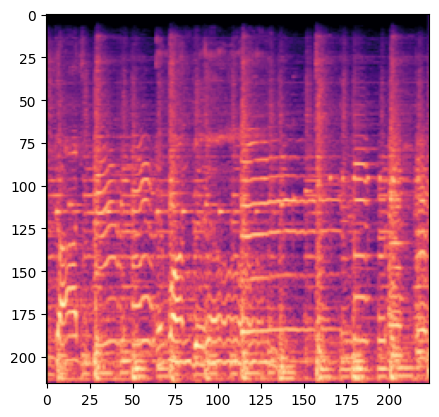

In [7]:
image=test_generator[0][0][0]
# Mostrar el array como una imagen
plt.imshow(image)
plt.show()


In [19]:
import time
start_time = time.perf_counter()
print(model.predict(image.reshape(1,216,224,3)))

# Tu código aquí

elapsed_time = time.perf_counter() - start_time
print(f"Tiempo transcurrido: {elapsed_time} segundos")


1/1 [==============================] - 0s 15ms/step
[[9.9716800e-01 2.9040791e-06 1.5788544e-03 5.0641400e-05 3.8526291e-06
  3.9927664e-04 2.0508494e-08 3.8159708e-08 7.7327510e-04 2.3109209e-05]]
Tiempo transcurrido: 0.04529609999985951 segundos


In [ ]:
#calculating features_map
features = layer1_model.predict(image.reshape(1,216,224,3))

fig = plt.figure(figsize=(20,15))
for i in range(1,features.shape[3]+1):

    plt.subplot(8,8,i)
    plt.imshow(features[0,:,:,i-1] , cmap='gray')
    
plt.show()

In [ ]:
for i in range(len(model.layers)):
    layer = model.layers[i]
    if 'conv' not in layer.name:
        continue    
    print(i , layer.name , layer.output.shape)

In [ ]:
outputs = [model.layers[i].output for i in blocks]

model2 = Model( inputs= model.inputs, outputs = outputs)

feature_map = model2.predict(image.reshape(1,216,224,3))

for j,fmap in zip(blocks,feature_map):
    fig = plt.figure(figsize=(15,20))
    #https://stackoverflow.com/a/12444777
    fig.suptitle("BLOCK_{}".format(j) , fontsize=20)
    
    for i in range(1,fmap.shape[3]):

        plt.subplot(8,8,i)
        plt.imshow(fmap[0,:,:,i] , cmap='magma')
    plt.savefig(f"C:\Diego\music-genre-classifier\grafica/feature_maps/feature_maps_block_{j}.png")
        
    
plt.show()

In [ ]:
model.summary()